In [ ]:
# The Julia boostrap block
# This should be run for the first time to install Julia kernel, and then refresh this page (e.g., Ctrl-R)
# so that colab will redirect to the installed Julia kernel
# and then doing your own work

# 1. install latest Julia using jill.py
#    tip: one can install specific Julia version using e.g., `jill install 1.7`
!pip install jill && jill install --upstream Official --confirm
# 2. install IJulia kernel
! julia -e 'using Pkg; pkg"add IJulia, Plots, Printf"; using IJulia; installkernel("Julia")'
# 3. hot-fix patch to strip the version suffix of the installed kernel so that this notebook kernelspec is version agnostic
!jupyter kernelspec install $(jupyter kernelspec list | grep julia | tr -s ' ' | cut -d' ' -f3) --replace --name julia

In [22]:
# code below is modified from http://hplgit.github.io/num-methods-for-PDEs/doc/pub/wave/html/._wave001.html
using Plots, Printf

function solver(I, V, f, c, L, dt, C, T)
    # Solve u_tt=c^2*u_xx + f on (0,L)x(0,T].
    # Dirichlet boundary
    # u(x, t=0) = I(x)
    # u_t(x, t=0) = V(x)
     
    t = Vector(0:dt:T)  # Mesh points in time
    dx = dt*c/C
    x = Vector(0:dx:L)       # Mesh points in space
    C2 = C^2

    Nx = length(x)
    Nt = length(t)-1
    # Make sure dx and dt are compatible with x and t
    dx = x[2] - x[1]
    dt = t[2] - t[1]


    u     = zeros(Nx)   # Solution array at new time level
    u_n   = zeros(Nx)   # Solution at 1 time level back
    u_nm1 = zeros(Nx)   # Solution at 2 time levels back
    sol = zeros(Nx, Nt+1) # store the final solution in a matrix
    sol[:,1] = I.(x)

    # Load initial condition into u_n
    for i in 1:Nx
        u_n[i] = I(x[i])
    end


    # Special formula for first time step
    n = 1
    for i in 2:Nx-1
        u[i] = u_n[i] + dt*V(x[i]) + 
               0.5*C2*(u_n[i-1] - 2*u_n[i] + u_n[i+1]) + 
               0.5*dt^2*f(x[i], t[n])
    end
    u[1] = 0;  u[end] = 0
    sol[:,2] = copy(u)

    # Switch variables before next step
    u_nm1, u_n, u = u_n, u, u_nm1

    for n in 2:Nt
        # Update all inner points at time t[n+1]
        for i in 2:Nx-1
            u[i] = - u_nm1[i] + 2*u_n[i] + 
                     C2*(u_n[i-1] - 2*u_n[i] + u_n[i+1]) + 
                     dt^2*f(x[i], t[n])
        end

        # Insert boundary conditions
        u[1] = 0;  u[end] = 0
        sol[:,n+1] = copy(u)

        # Switch variables before next step
        u_nm1, u_n, u = u_n, u, u_nm1
    end

    return u, x, t, sol
end

function myplot(x, t, sol)
    anim = @animate for (ti, t) in enumerate(t)
        plot(x, sol[:,ti], ylims=(minimum(sol), maximum(sol)),label=@sprintf("t=%.5f",t))
    end
    return anim
end

myplot (generic function with 1 method)

┌ Info: Saved animation to 
│   fn = /content/sincos.gif
└ @ Plots /root/.julia/packages/Plots/rDbWY/src/animation.jl:114


Plots.AnimatedGif("/content/sincos.gif")
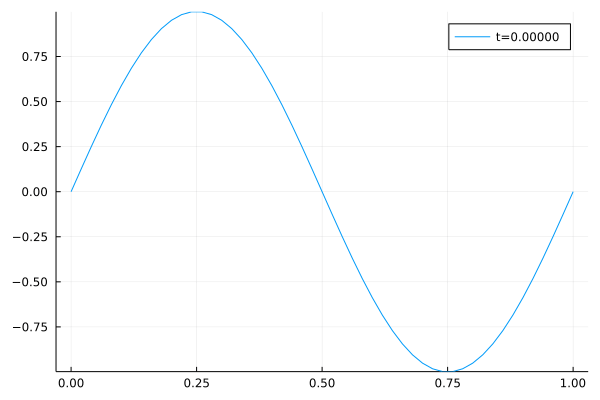

In [23]:
function sincos()
    n = m = 2.0
    L = 1.0
    c = 1.0
    C = 0.75
    Nx = 50
    dt = C*(L/Nx)/c
    T = 1
    u_exact(x, t) = cospi(m/L*t)*sinpi(m/L*x)
    I(x) = u_exact(x, 0)
    V(x) = 0.0
    f(x, t) = 0.0
    return solver(I, V, f, c, L, dt, C, T)
end

u, x, t, sol = sincos()

anim = myplot(x,t,sol)

gif(anim, "sincos.gif", fps=20)

┌ Info: Saved animation to 
│   fn = /content/guitar.gif
└ @ Plots /root/.julia/packages/Plots/rDbWY/src/animation.jl:114


Plots.AnimatedGif("/content/guitar.gif")
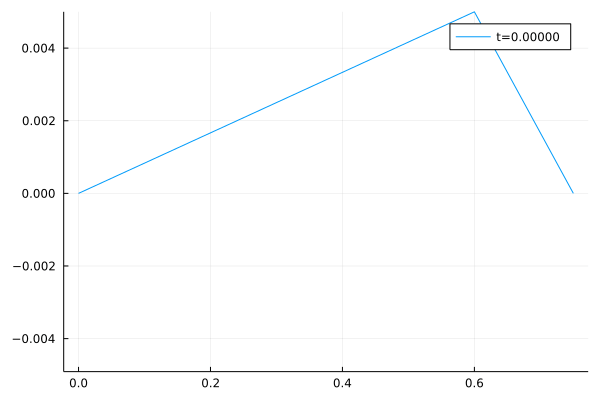

In [24]:
function guitar(C)
    """Triangular wave (pulled guitar string)."""
    L = 0.75
    x0 = 0.8*L
    a = 0.005
    freq = 440
    wavelength = 2*L
    c = freq*wavelength
    omega = 2*pi*freq
    num_periods = 1
    T = 2*pi/omega*num_periods
    # Choose dt the same as the stability limit for Nx=50
    dt = L/50.0/c

    I(x) = x < x0 ? a*x/x0 : a/(L-x0)*(L-x)

    umin = -1.2*a;  umax = -umin
    V(x) = 0.0
    f(x, t) = 0.0
    return solver(I, V, f, c, L, dt, C, T)
end

u, x, t, sol = guitar(0.8)

anim = myplot(x,t,sol)

gif(anim, "guitar.gif", fps=8)

┌ Info: Saved animation to 
│   fn = /content/quadratic.gif
└ @ Plots /root/.julia/packages/Plots/rDbWY/src/animation.jl:114


Plots.AnimatedGif("/content/quadratic.gif")
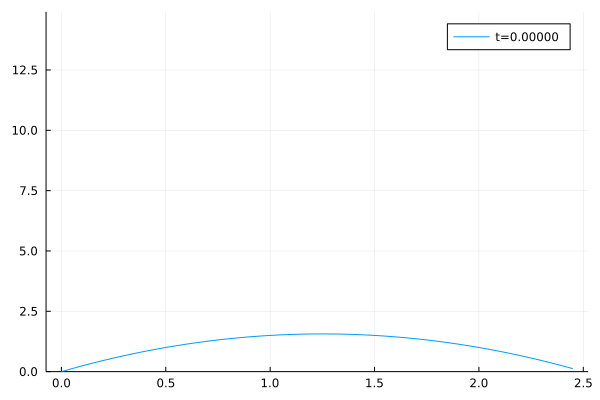

In [25]:
function quadratic()
    """Check that u(x,t)=x(L-x)(1+t/2) is exactly reproduced."""

    u_exact(x, t) = x*(L-x)*(1 + 0.5*t)

    I(x) = u_exact(x, 0)

    V(x) = 0.5*u_exact(x, 0)

    f(x, t) = 2*(1 + 0.5*t)*c^2

    L = 2.5
    c = 1.5
    C = 0.75
    Nx = 50  
    dt = C*(L/Nx)/c
    T = 18

    return solver(I, V, f, c, L, dt, C, T)
end

u, x, t, sol = quadratic()

anim = myplot(x,t,sol)

gif(anim, "quadratic.gif", fps=30)